# Assignment 01 - Dog Breed

Identifying dog breeds using the [Stanford Dogs Dataset](https://www.kaggle.com/competitions/dog-breed-identification/overview)

Thiago Amado Costa


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
# import tensorflow as tf
from cv2 import imread, resize

from pipeline import baseline_model, svm_classifier, create_cnn

## Reading Dataset

- labels.csv is composed of the name of the image (id) and its corresponding class
- only for the train images

In [4]:
df = pd.read_csv('dogs/labels.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10222 entries, 0 to 10221
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10222 non-null  object
 1   breed   10222 non-null  object
dtypes: object(2)
memory usage: 159.8+ KB


## Train - SVM

- converting images to grayscale
- creating X (pixels) and y (breeds)

In [5]:
breeds = sorted(list(set(df['breed']))) # sorted list of unique values of y (breeds)
num_breeds = dict(zip(breeds, range(len(breeds)))) # assign each breed a number 0..120

def convert_img(id):
    img = imread(f'dogs/train/{id}.jpg')
    img = resize(img, (64,64))
    return img

def create_values_and_labels():
    y = []
    X = []
    for row in df.to_numpy():
        converted_img = convert_img(row[0])
        y.append(num_breeds[row[1]])
        X.append(converted_img)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

X,y = create_values_and_labels()

del breeds 
del num_breeds
del df

In [6]:
X = X / 255

- plotting a dog as example

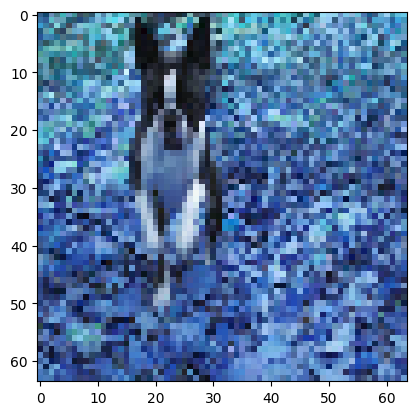

In [7]:
plt.imshow(X[0])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
i = 5000

In [8]:
X_train_flat = []
X_test_flat = []

for i in range(X_train.shape[0]):
    X_train_flat.append(np.mean(X_train[i], axis=-1, keepdims=True).flatten())

for i in range(X_test.shape[0]):
    X_test_flat.append(np.mean(X_test[i], axis=-1, keepdims=True).flatten())
    
X_train_flat = np.asarray(X_train_flat) 
X_test_flat = np.asarray(X_test_flat) 

In [12]:
print(f'Dummy accuracy: {baseline_model(X_train_flat, y_train, X_test_flat, y_test)}')

Dummy accuracy: 0.009779951100244499


In [13]:
s = svm_classifier(X_train_flat, y_train, X_test_flat, y_test, kernel="linear")
print(f'SVM linear accuracy: {s}')

SVM linear accuracy: 0.034229828850855744


In [14]:
s = svm_classifier(X_train_flat, y_train, X_test_flat, y_test, kernel="poly")
print(f'SVM poly accuracy: {s}')

SVM poly accuracy: 0.033251833740831294


In [15]:
s = svm_classifier(X_train_flat, y_train, X_test_flat, y_test, kernel="poly", num_samples=X_train.shape[0])
print(f'SVM poly accuracy (all samples): {s}')

SVM poly accuracy (all samples): 0.040097799511002445


## Training - CNN

Epoch 1/10
64/64 [==============================] - 121s 2s/step - loss: 4.7911 - accuracy: 0.0102 - val_loss: 4.7557 - val_accuracy: 0.0166
Epoch 2/10
64/64 [==============================] - 118s 2s/step - loss: 4.7194 - accuracy: 0.0208 - val_loss: 4.6687 - val_accuracy: 0.0318
Epoch 3/10
64/64 [==============================] - 120s 2s/step - loss: 4.5349 - accuracy: 0.0505 - val_loss: 4.5409 - val_accuracy: 0.0533
Epoch 4/10
64/64 [==============================] - 119s 2s/step - loss: 4.2784 - accuracy: 0.0823 - val_loss: 4.2989 - val_accuracy: 0.0792
Epoch 5/10
64/64 [==============================] - 118s 2s/step - loss: 3.8597 - accuracy: 0.1482 - val_loss: 4.1872 - val_accuracy: 0.1017
Epoch 6/10
64/64 [==============================] - 118s 2s/step - loss: 3.3527 - accuracy: 0.2315 - val_loss: 3.9845 - val_accuracy: 0.1516
Epoch 7/10
64/64 [==============================] - 118s 2s/step - loss: 2.7425 - accuracy: 0.3369 - val_loss: 3.9234 - val_accuracy: 0.1623
Epoch 8/10
64

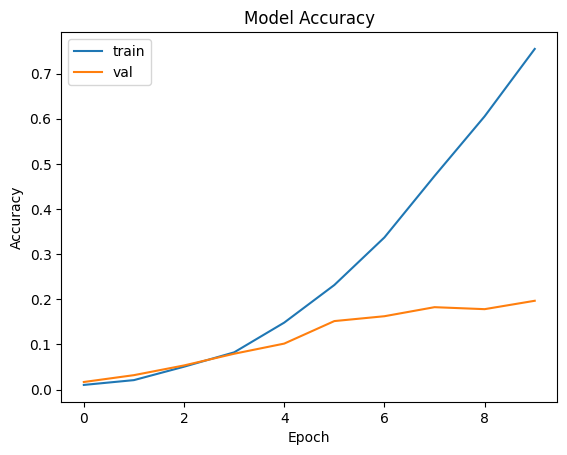

In [10]:
cnn = create_cnn(120)
history = cnn.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Results Analysis

By applying the same approach from the MNIST dataset, it is clear that it is not sufficient to get a good accuracy on the dog breeds dataset.
As seen in the Model Accuracy plot, it is also clear that the model is overfitting, and to fix that changes such as Data Augmentation are necessary.